### CLAD-C: Benchmark Introduction

This notebook contains a short introduction to the CLAD-C benchmark, a classification benchmark for continual learning from a stream of chronologically ordered images. A chronological stream induces continous, yet realistic distribution shifts, both in the label distribution and the domain distributions. The image below gives an overview of the distribution changes throughout the stream. The x-axis displays the time, along which the images are given. An example of a distribution shift happens between $T_1$ and $T_2$, which is during the night. If you look at the classes that are present during this period, you'll see that there's almost no pedestrians and cyclist left. A similar thing happens during the other night, or when the car is on the highway. Also, the tricycle is most frequent in Guangzhou, not showing up much in the other cities. Beyond this, there are much more frequent but smaller distribution shifts not clearly visible in this plot.

<p align="center">
    <img src="./static/3a_collage.png" width="800">
</p>

The goal of the challenge is to maximize $AMCA$, or Average Mean Class Accuracy. This is the mean accuracy over all classes, averaged at different points during the datastream. We chose this metric because of the high class imbalance in the datastream and such that each class is equally important. We calculate this mean accuracy at different points during the stream, since the continual learner should be resistent to distributions shifts which isn't tested if you only test at the end of the stream. Somewhat arbitrary, we chose the switches between day and night as testing points (the $T_i$ in the plot above). This is because we noted that at these points naively trainig is most likely to have failed. Summarized, the metric we use in this challenge is:
$$
AMCA = \frac{1}{T} \sum_{t} \frac{1}{C} \sum_c a_{c, t}
$$
where $T$ are number of testing points and $C$ is the number of classes.

The original challenge at ICCV had some restrictions, which we believe are still worth considering now. Of course, if there's a good reason to deviate from them, there's no reason for not doing so now. Below are the original rules, order by our perceived importance at this point.

1. Maximal replay memory size is 1000 samples
2. Maximum batch size is 10
3. No computationally heavy operations are allowed between training and testing (i.e. ideally the model should almost always be directly usable for predictions).
4. Maximum number of parameters are 105% those of a typical Resnet50

In [13]:
%matplotlib inline
from clad import *
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

In [14]:
root = "../../data"
ds = get_cladc_train(root, transform=lambda x: x)[0]
ds._sorted = False  # This should almost never be done, but for illustration we don't need to adhere to the sorted version

The raw SODA10M data are images with bbox annotations. For instance, see the image below.

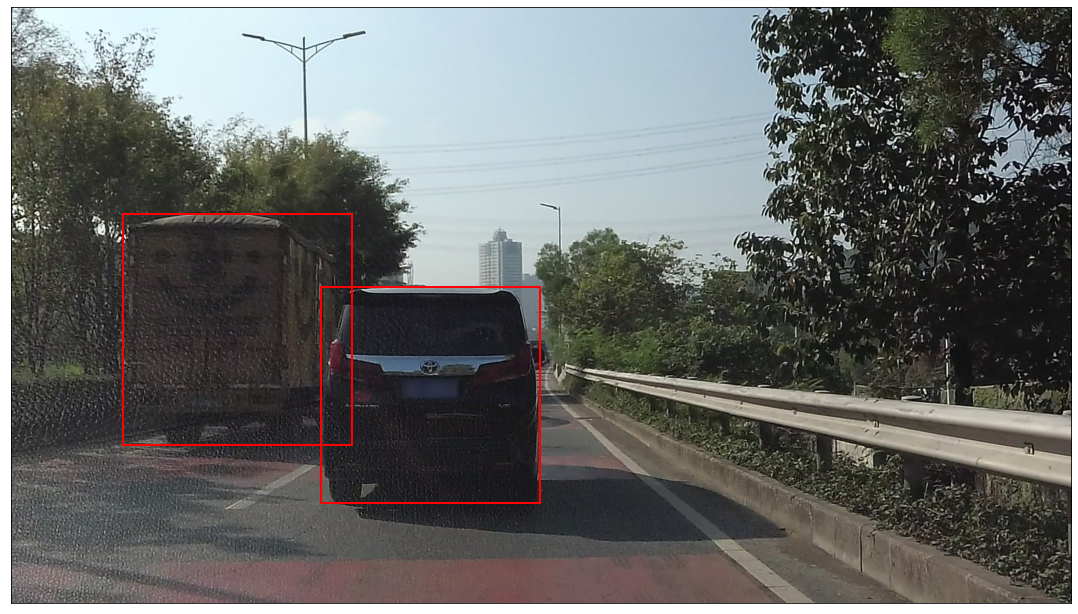

In [15]:
img_index = 2

img_annot = ds.img_annotations[img_index]
img_id = img_annot['id']
obj_ids = [obj for obj in ds.obj_annotations if ds.obj_annotations[obj]['image_id'] == img_id]

fig, ax = plt.subplots(1,1, figsize=(19, 11))
img = Image.open(os.path.join(ds.img_folder, img_annot['file_name']))
ax.imshow(img)

for obj in obj_ids:
    bbox = ds.obj_annotations[obj]['bbox']
    ax.add_patch(Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, lw=2, edgecolor='r'))

ax.set_xticks([])
ax.set_yticks([])
plt.show()

From these images, objects are cut out by taking the ground truth bounding box, making it square and rescaling it to 64x64 pixels. The default transfrom (not shown) also normalizes the images. As the examples below show, the same objects will be visible in multiple subsequent batches because of the chronoglogical nature of the benchmark.

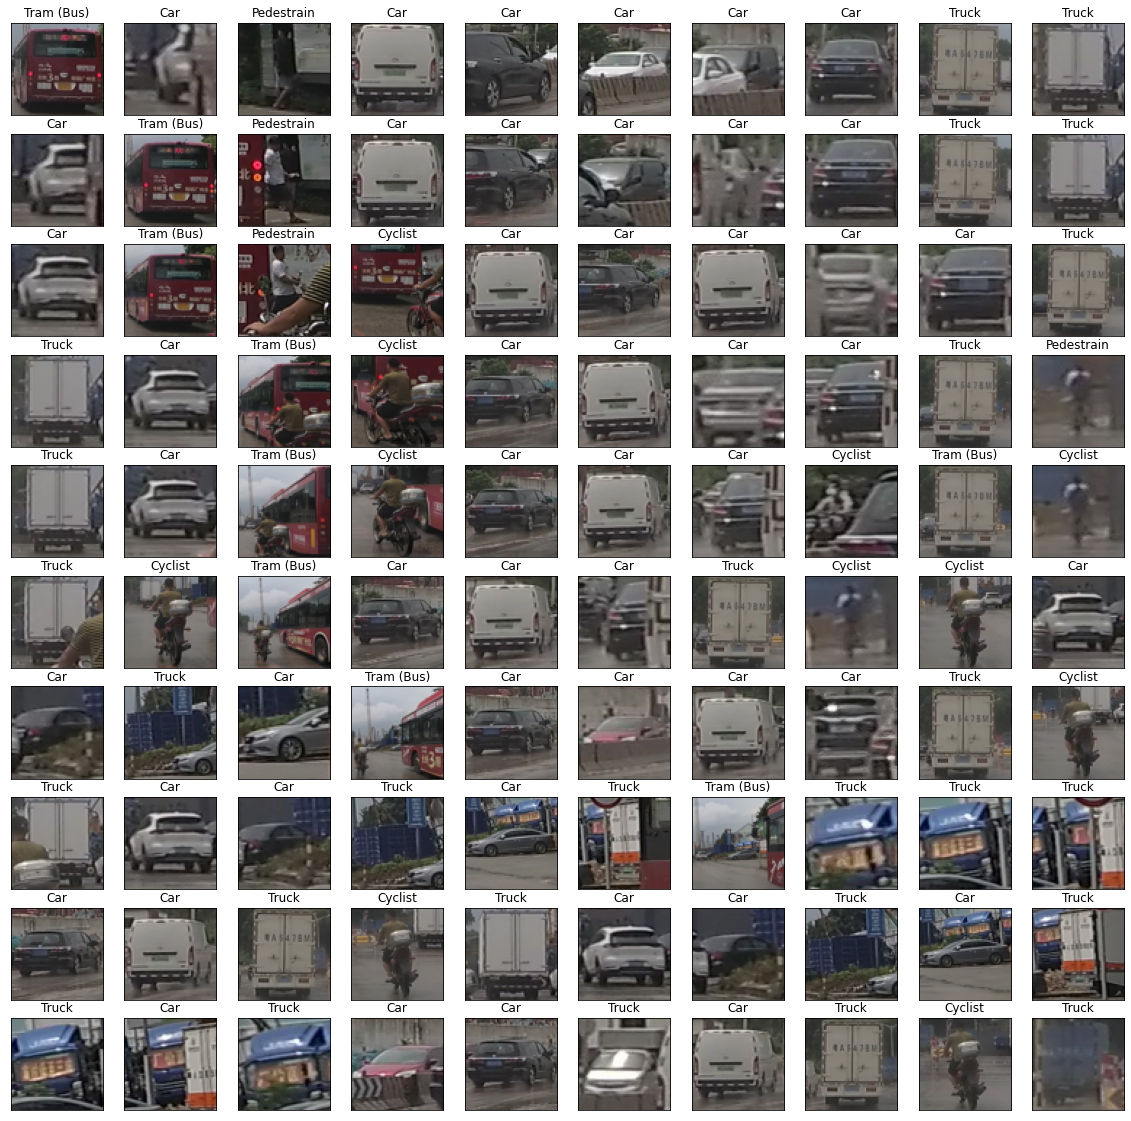

In [16]:
ax_h, ax_w = 10, 10
start_idx = 100
fig, axes = plt.subplots(ax_w, ax_h, figsize=(2 * ax_h, 2 * ax_w))
iter_axes = iter(axes.flatten())

for i in range(start_idx, start_idx + ax_w * ax_h):
    ax = next(iter_axes)
    img, label = ds[i]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(SODA_CATEGORIES[label])

plt.show()